# N2 Method

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from streng.tools.bilin import Bilin
import streng.codes.eurocodes.ec8.cls.seismic_action.spectra as spec_ec8
from streng.codes.usa.atc40.cls.nl_static_analysis.n2 import N2Method
from streng.codes.usa.atc40.cls.nl_static_analysis.n2 import StructureProperties
from streng.codes.usa.atc40.cls.nl_static_analysis.n2 import Demand

## Step 1: Data

In [2]:
bl = Bilin()
# bl.load_space_delimited(r'D:/MyBooks/TEI/RepairsExample/sapfiles/fema/PushoverCurve_modal.pushcurve', ' ')
bl.curve_ini.load_delimited(r'http://seivas.net/mkd/PushoverCurve_modal.pushcurve', ' ')

mystructure = StructureProperties(m = np.array([39.08, 39.08, 39.08]),
                                  φ = np.array([0.0483, 0.0920, 0.1217]),
                                  T0 = 0.753,
                                  pushover_curve_F = bl.curve_ini.y,
                                  pushover_curve_δ = bl.curve_ini.x)

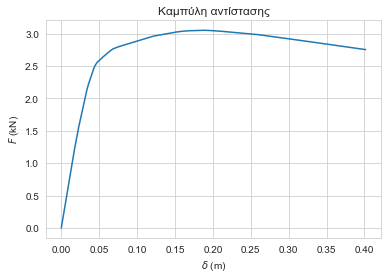

In [3]:
plt.plot(mystructure.Sd, mystructure.Sa)
plt.ylabel('$F$ (kN)') 
plt.xlabel('$δ$ (m)') #'μθpl'  
plt.title('Καμπύλη αντίστασης')
plt.show()

In [4]:
T_range = np.linspace(1e-10, 4, 401)

mydemand = Demand(T_range=T_range,
                  Sa=None,
                  Sd=None,
                  TC=None)

mydemand.ec8_elastic(αgR=0.24*9.81,
                          γI=1.0,
                          ground_type = 'C',
                          spectrum_type = 1,
                          η =1.0,
                          q=1.0,
                          β=0.2)

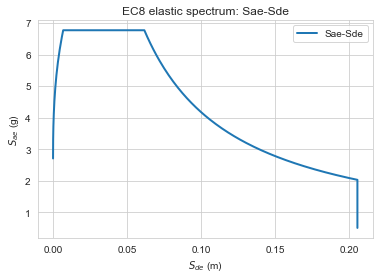

In [5]:
plt.plot(mydemand.Sd, mydemand.Sa, lw=2, label='Sae-Sde')
plt.ylabel('$S_{ae}$ (g)') 
plt.xlabel('$S_{de}$ (m)') 
plt.title('EC8 elastic spectrum: Sae-Sde')
plt.legend()
plt.show()

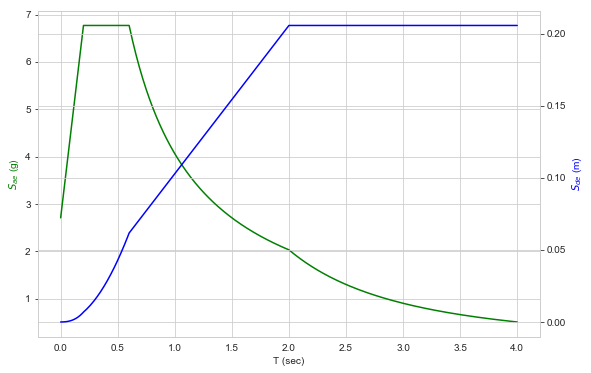

In [6]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(9.0, 6.0))

ax2 = ax1.twinx()
ax1.plot(T_range, mydemand.Sa, 'g-')
ax2.plot(T_range, mydemand.Sd, 'b-')

ax1.set_xlabel('T (sec)')
ax1.set_ylabel('$S_{ae}$ (g)', color='g')
ax2.set_ylabel('$S_{de}$ (m)', color='b')

plt.show()

## Step 2: Seismic demand in AD format

In [7]:
myN2 = N2Method(structure = mystructure,
                demand = mydemand)

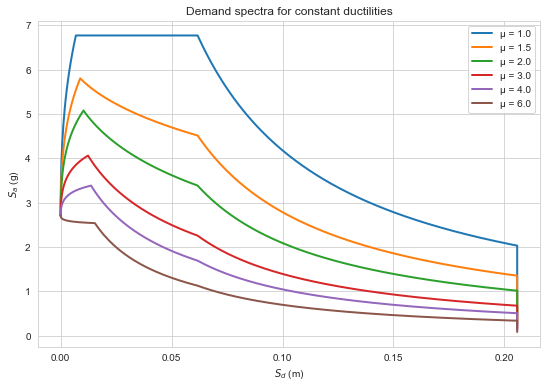

In [8]:
plt.figure(figsize=(9.0, 6.0))
μs = [1.0, 1.5, 2.0, 3.0, 4.0, 6.0]
for μ in μs:
    plt.plot(myN2.Sd_for_μ(μ), myN2.Sa_for_μ(μ), lw=2, label=f'μ = {μ:.1f}')
plt.ylabel('$S_{a}$ (g)') 
plt.xlabel('$S_{d}$ (m)') 
plt.title('Demand spectra for constant ductilities')
plt.legend()
plt.show()



## Step 3: Pushover analysis

## Step 4: Equivalent SDOF

In [9]:
print(f'PF1 = {myN2.structure.PF1:.4f}')
print(f'α1 = {myN2.structure.α1:.4f}')
print(f'φroof1 = {myN2.structure.φroof1:.4f}')

PF1 = 10.2313
α1 = 0.8935
φroof1 = 0.1217


In [10]:
bl = Bilin()
bl.elastoplastic = True
bl.curve_ini.x = myN2.structure.Sd
bl.curve_ini.y = myN2.structure.Sa
bl.calc()

In [11]:
Tstar = bl.bilinear_curve.T0

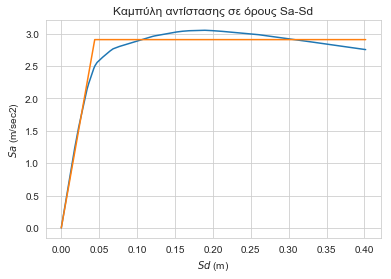

In [12]:
plt.plot(myN2.structure.Sd, myN2.structure.Sa)
plt.plot(bl.bilinear_curve.d_array, bl.bilinear_curve.a_array)
plt.ylabel('$Sa$ (m/sec2)') 
plt.xlabel('$Sd$ (m)') #'μθpl'  
plt.title('Καμπύλη αντίστασης σε όρους Sa-Sd')
plt.show()

## Step 5: Seismic demand for the equivalent SDOF

In [13]:
spec = spec_ec8.SpectraEc8(αgR=0.24*9.81,
                          γI=1.0,
                          ground_type = 'C',
                          spectrum_type = 1,
                          η =1.0,
                          q=1.0,
                          β=0.2)

Sae_for_T = spec.Se(Tstar)
Sde_for_T = spec.SDe(Tstar)

Rμ = Sae_for_T / bl.bilinear_curve.ay

print(f'Rμ = {Rμ:.3f}')
μ = Rμ

Rμ = 1.805


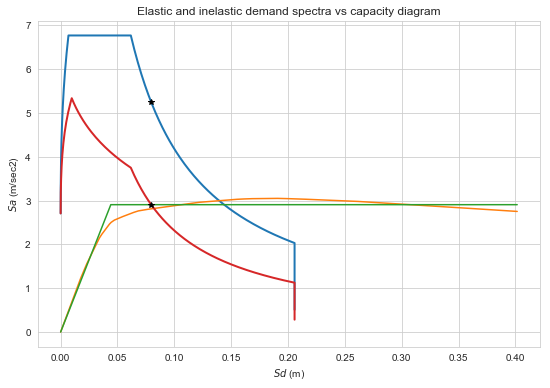

In [14]:
plt.figure(figsize=(9.0, 6.0))
plt.plot(myN2.Sd_for_μ(1.0), myN2.Sa_for_μ(1.0), lw=2, label=f'μ = {μ:.1f}')
plt.plot(myN2.structure.Sd, myN2.structure.Sa)
plt.plot(bl.bilinear_curve.d_array, bl.bilinear_curve.a_array)
plt.plot(Sde_for_T, Sae_for_T,'*k')
plt.plot(myN2.Sd_for_μ(μ), myN2.Sa_for_μ(μ), lw=2, label=f'μ = {μ:.1f}')
plt.plot(Sde_for_T, Sae_for_T/μ,'*k')
plt.ylabel('$Sa$ (m/sec2)') 
plt.xlabel('$Sd$ (m)') #'μθpl'  
plt.title('Elastic and inelastic demand spectra vs capacity diagram')
plt.show()

In [15]:
print(f'Sd = {Sde_for_T:.3f}m')

Sd = 0.080m


In [16]:
# διαφορετικά
Sd_alter = μ * bl.bilinear_curve.dy
print(f'Sd = {Sd_alter:.3f}m')

Sd = 0.080m
